# Fixing VGG16 Image Input Issues

When I first ran the notebook `image-to-vgg16.ipynb`, 66 of the images couldn't be processed by the model. The issue seemed to be because they had 4 color channels rather than 3 (which VGG16 expects). This is probably because a few of the source images are `RGBA` (meaning they also have an alpha channel) not just `RGB`.

In this notebook I'll start by exploring the images to confirm that my suspicion about extraneous alpha channels is correct. If I'm right, I'll just throw away the alpha channel, and re-save the image -- since movies (at least as of 2020) are inherently only RGB and therefore don't need any transparency.

In [1]:
import pathlib

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [3]:
from PIL import Image
from tqdm import tqdm

In processing the images, I found errors that seem to relate to the number of image channels in a few of the images. Let's look through the images and see which ones have 4 channels.

The stills for each movie are stored in a folder together (named with the `movie-id`) inside the `data/vgg16images/stills` folder.

In [4]:
stills_dir = pathlib.Path("data/vgg16images/stills")
stills_dir

PosixPath('data/vgg16images/stills')

First, we'll grab an example image to experiment with

In [5]:
test_image = next(stills_dir.glob("0000/*.png"))
test_image

PosixPath('data/vgg16images/stills/0000/0000_10CloverfieldLane_00042.png')

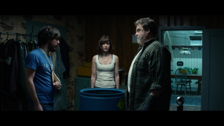

In [6]:
img = Image.open(test_image.open("rb"))
img

In [7]:
img.mode

'RGB'

In [8]:
img.convert("RGBA").mode

'RGBA'

Now we can iterate through the images and find the images to focus on by picking out the images that aren't `RGB`.

Based on the errors from the VGG16 model, there should be `66` images.

In [9]:
# List for storing the problem images
target_images = []

# Iterable that will go through the image
# paths and show a progress bar
stills_iter = tqdm(
    stills_dir.glob("*/*.png"),
    desc="Images processed",
    total=sum(1 for _ in stills_dir.glob("*/*.png")),
    ncols=100
)

for still_path in stills_iter:
    # Load in the image
    img = Image.open(still_path.open("rb"))
    # If the image isn't RGB, it will probably
    # cause problems for VGG16
    if img.mode != "RGB":
        target_images.append((still_path,img))
    
# How many did we find?
print(f"Found {len(target_images)} target images.")

Images processed: 100%|██████████████████████████████████| 132617/132617 [00:12<00:00, 10557.71it/s]

Found 66 target images.


Great, we got 66 images as expected.

Let's look at one of the examples.

Image path: data/vgg16images/stills/0472/0473_DistantVoicesStillLives_00000.png
Image mode: RGBA


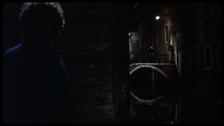

In [10]:
print("Image path:", target_images[0][0])
print("Image mode:", target_images[0][1].mode)
target_images[0][1]

Is there actually any useful information in the alpha channel? (_aka_ any values less than 255)

In [11]:
np.array(target_images[0][1].getchannel("A")).min()

255

Nope! The alpha channel is unused in this image.

Are all the problem images `RGBA`?

In [12]:
set(img[1].mode for img in target_images)

{'RGBA'}

Are all the alpha channels unused?

In [13]:
set(np.array(img[1].getchannel("A")).min() for img in target_images)

{255}

Yes! All of the problem-images seem to just have extraneous alpha channels. Let's convert the images to RGB and then re-save them.

In [14]:
for path, img in tqdm(target_images):
    img.convert("RGB").save(path)

100%|██████████| 66/66 [00:00<00:00, 67.54it/s]


Great! Now let's just re-run the code from the earlier line to confirm that we fixed the issue...

In [15]:
target_images = []
stills_iter = tqdm(
    stills_dir.glob("*/*.png"),
    total=sum(1 for _ in stills_dir.glob("*/*.png")),
)
for still_path in stills_iter:
    img = Image.open(still_path.open("rb"))
    if img.mode != "RGB":
        target_images.append(still_path)
    
# How many did we find?
print(f"Found {len(target_images)} target images.")

100%|██████████| 132617/132617 [00:13<00:00, 9560.26it/s] 

Found 0 target images.


Great! That means it worked! Now we can go back to processing the images with VGG16.